# Lecture 14: Multiclass Classification and Ranking
***

<img src="figs/starwarsbanner.png",width=1100,height=50>

Reminder:  Scroll down and shift-enter the [[helper functions]](#helpers)
***

<br>
<br>

### Problem 1: Multiclass Issues 
***

**Q**: What are some potential difficulties with the One-vs-All binary classification scheme? 


**Q**: What are some potential remedies for this? 

[[Problem 1 Answers]](#prob1ans)

<br><br>


<br>
<br>

### Problem 2: Multiclass Classification and Error Correcting Output Codes 
***

We've seen the One-vs-All and All-Pairs framework for reducing multiclass classification to binary classification.  In this problem we explore a similar (but different) framework that has become popular based on the theory of error correcting codes.  Consider the following binary coding matrix: 

$$
\begin{array}{ccccc}
\hline
\textrm{Class} & h_0 & h_1 & h_2 & h_3 & h_4 \\ 
\hline
0 & 1 & 0 & 1 & 0 & 1 \\
1 & 0 & 0 & 1 & 1 & 1 \\
2 & 1 & 1 & 0 & 0 & 0 \\
3 & 1 & 1 & 1 & 1 & 0 \\
\hline
\end{array}
$$

Think of each column in the binary coding matrix as a hypothesis where the entries in the columns define binary *super classes*. The general idea is similar to One-vs-All and All-Pairs in the sense that we'll assign binary labels to different classes for each classifier, perform binary classifications, and then assign a final class to a query point according to some procedure.   The motivation behind the ECOC scheme is that the combinations of the bit representation of each class should be robust to minor classification errors.  

To see this, notice that in the example above each bit-string or *codeword* associated with each class differs by at least **two** bits, i.e. their Hamming Distances are at least 2.  What this means is that if you make predictions based on the trained binary classifiers to obtain a codeword representation of a query point, even if it's off by one predicted bit you **might** be able to obtain the correct general classification by using a distance measure.  

**Example**: Suppose you want to predict the nationality of a person given their last name.  Your training set is 

$$
\begin{array}{ccc}
\hline 
\textrm{Korean} & \textrm{German} & \textrm{Argentine} \\
\hline 
\textrm{Park} & \textrm{Mann} & \textrm{Puig} \\
\textrm{Kim} & \textrm{Berndt} & \textrm{Borges} \\
\textrm{Kwon} & \textrm{Grass} & \textrm{Cortazar} \\
\hline 
\end{array}
$$

Suppose that the codebook you will use looks like 

$$
\begin{array}{ccccc}
\hline
\textrm{Class} & h_0 & h_1 & h_2 & h_3 \\ 
\hline
\textrm{Korean}    & 1 & 0 & 0 & 1  \\
\textrm{German}    & 0 & 0 & 1 & 0  \\
\textrm{Argentine} & 1 & 1 & 1 & 0  \\
\hline
\end{array}
$$

**Q**: What are the binary labels corresponding to each training example under each hypothesis? 


**Q**: Suppose that the predictions for a given query point are given by $\hat{y} = (0,0,0,1)$.  Which class would we predict? 

**Q**: Suppose that the predictions for a given query point are given by $\hat{y} = (1,1,0,0)$.  Which class would we predict? 

**Q**: For a classification problem with three classes, what would the codebook be corresponding to One-vs-All classification? 

**Q**: How many useful codewords can you have for a three-class classifier? 

**Q**: What is a general formula for the number of useful hypotheses in a K-class setting? 

For more information on ECOCs in multiclass classification check out the original paper by <a href="https://www.jair.org/media/105/live-105-1426-jair.pdf">Dietterich and Bakiri</a> or this paper by <a href="http://amstat.tandfonline.com/doi/abs/10.1080/10618600.1998.10474782">James and Hastie</a>. 

[[Problem 2 Answers]](#prob2ans)

<br><br>


<br>
<br>

### Problem 3: Rank SVM 
***

*This problem is based on the blog post <a href="http://fa.bianp.net/blog/2012/learning-to-rank-with-scikit-learn-the-pairwise-transform/#fnref:1">Learning to Rank with Sci-Kit Learn: The Pairwise Transform</a> by Fabian Pedregosa *

<br>

Suppose in a ranking application you have data from two distinct comparable blocks (i.e. in web search you might have data from a collection of webpages with respect to two different search queries).  Suppose further that for each query an expect has labeled the data with labels $y \in {0,1,2}$ where $0, 1,$ and $2$ correspond to $\texttt{irrelevant}$, $\texttt{mildly relevant}$, and $\texttt{super relevant}$, respectively.  The following synthetic data gives an example of such labeled data with two features ${\bf x} = (x_1, x_2)$.  Notice that there is a vector ${\bf w}$ that accurately encodes the relevance ranking for each block of data corresponding to a different query by projection of the data point onto ${\bf w}$.  

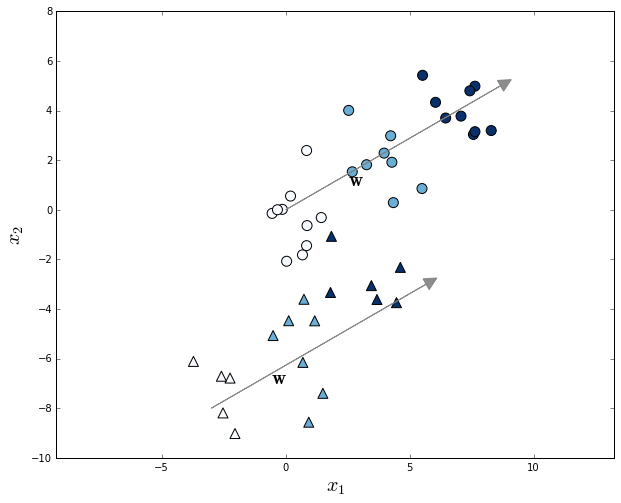

In [12]:
X_train, y_train, b_train, X_test, y_test, b_test, w = get_plot_data()

Our goal is to learn an approximation, $\hat{\bf w}$, that can be used to accurately rate future unseen data based on alternate queries.  One (foolish) way to attempt this is to fit a a linear classifier to the data.  Let's try this with simple Ridge Regression. 

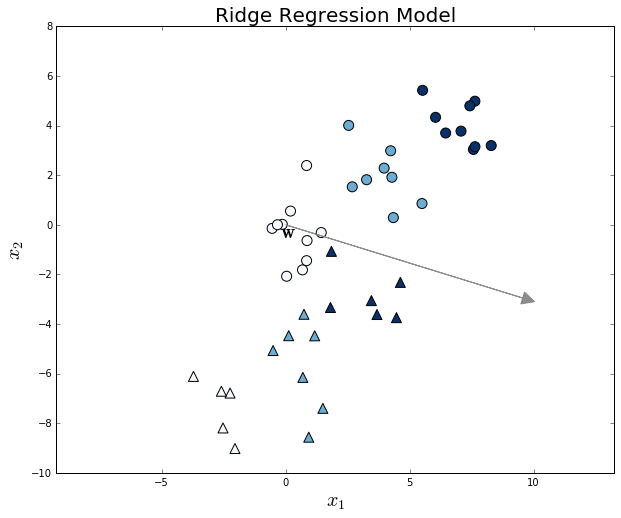

In [13]:
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
wridge = regr.coef_ / np.linalg.norm(regr.coef_)
plot_data_w(X_train, y_train, b_train, wridge, "Ridge Regression Model")

Here we see the problem.  Because we have not done anything to tell the learning algorithm to treat the two different sets of query data separately, we get a linear model that is skewed by the pair-wise interaction of query-document pairs from different queries. 

To evaluate our model we'll use *Kendall's tau correlation coefficient* on each set of query data, given by 

$$
\tau = \frac{P-Q}{P+Q}
$$

where $P$ is the number of concordant pairs (i.e. pairs that are correctly ordered w.r.t. to the labeling) and $Q$ is the number of discordant pairs (i.e. pairs that are incorrectly ordered w.r.t. the labeling).  Note that the sklearn implementation of Kendall's Tau is slightly different than this, but in any case it gives a measure in $[-1, 1]$ where numbers close to $1$ indicate a faithful ordering in the data and numbers close to $-1$ indicate a poor ordering of the data.  

In [14]:
for i in range(2):
    tau, _ = stats.kendalltau(
        regr.predict(X_test[b_test == i]), y_test[b_test == i])
    print('Kendall correlation coefficient for block %s: %.5f' % (i, tau))

Kendall correlation coefficient for block 0: 0.81661
Kendall correlation coefficient for block 1: 0.82064


**Q**: Which points in each block are mis-ranked by the Ridge Regression estimate of $\hat{\bf w}$? 

<br>

One way to get a more faithful approximation of ${\bf w}$ is to turn the problem into a binary classification problem using a pairwise transformation and then use a Support Vector Machine to do classification.  

The pairwise transformation we'll use is as follows 

$$
({\bf x}_k', y_k') = ({\bf x}_i - {\bf x}_j, \textrm{sign}(y_i - y_j)) ~~~ \textrm{for all comparable pairs} ~ (i,j) 
$$

**Q**: What do we mean by *for all comparable pairs*? 

**Q**: What dot he binary labels represent? 

The following plot shows the pairwise difference features.  The colors represent the size of the label differences. 

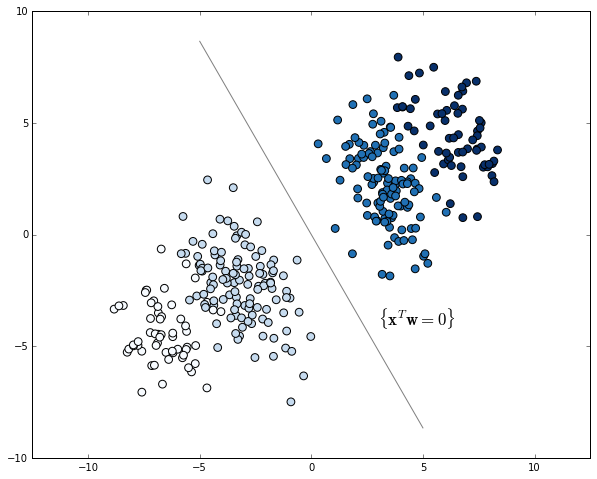

In [17]:
Xp, yp = get_plot_comparable_pairs(X_train, y_train, b_train, w)

 Notice that the true vector ${\bf w}$ perfectly separates the pair-wise differences.  This may not always be the case, for instance if there are discordant pairs in the training data due to mistakes in labeling by the experts. 
 
 Our goal now is to use a Support Vector Machine to learn an approximation $\hat{\bf w}$ to the true ranking vector ${\bf w}$. 

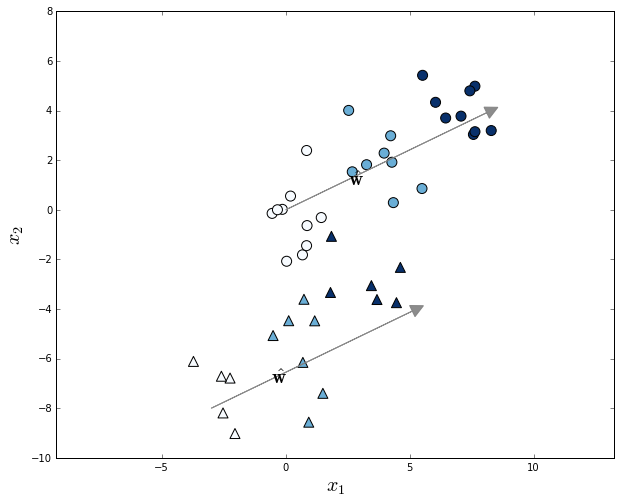

In [19]:
clf = svm.SVC(kernel="linear", C = 0.1)
clf.fit(Xp, yp)
wsvm = (clf.coef_ / np.linalg.norm(clf.coef_))[0]
plot_approximate_rank(X_train, y_train, b_train, wsvm)

Looks pretty good!  Let's compute Kendall's tau for the SVM-based ranking. 

In [20]:
for i in range(2):
    tau, _ = stats.kendalltau(
                np.dot(X_test[b_test == i], wsvm), y_test[b_test == i])
    print('Kendall correlation coefficient for block %s: %.5f' % (i, tau))

Kendall correlation coefficient for block 0: 0.83034
Kendall correlation coefficient for block 1: 0.83627


Notice that we obtained improvement over the Ridge Regression method. 

[[Problem 3 Answers]](#prob3ans)

<br><br>

<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>

<a id='prob1ans'></a>

### Problem 1: Multiclass Issues 
***

**Q**: What are some potential difficulties with the One-vs-All binary classification scheme? 


**A**: An obvious problem is class imbalance.  If you have an initially balanced data set with 5 class labels, then each binary classification in One-vs-All will have a class balance of 80%/20%. 

**Q**: What are some potential remedies for this? 

**A**: There are lots of things that you can try.  Here are some suggestions in order of increasing brilliance: 

**Undersampling**: You can undersample the $\texttt{NotK}$ class so that it is balanced with the $\texttt{IsK}$ class

**Oversampling**: You can oversample the $\texttt{IsK}$ class by synthetic means.  For example, in handwritten digit recognition (a problem with $K = 10$ classes) you can create synthetic data by applying elementary transformations to digit images (translation, rotation, skewing, etc).  There are fancier generic methods out there like <a href="https://www.jair.org/media/953/live-953-2037-jair.pdf">SMOTE</a>. 

**Undersampling Ensemble**: Divide the *all* parts of the data set into $K-1$ different training sets, train $K-1$ balanced binary classifiers, and then ensemble the results. 

**Cost Sensitive Learning**: Construct your loss functions so that they weight the minority class in a stronger way 

For more information on training imbalanced data sets see <a href="http://www.ijcst.com/icaccbie11/sp1/krishnaveni.pdf">this review</a>. 


<br>
<br>

<a id='prob2ans'></a>

### Problem 2: Multiclass Classification and Error Correcting Output Codes 
***

We've seen the One-vs-All and All-Pairs framework for reducing multiclass classification to binary classification.  In this problem we explore a similar (but different) framework that has become popular based on the theory of error correcting codes.  Consider the following binary coding matrix: 

$$
\begin{array}{ccccc}
\hline
\textrm{Class} & h_0 & h_1 & h_2 & h_3 & h_4 \\ 
\hline
0 & 1 & 0 & 1 & 0 & 1 \\
1 & 0 & 0 & 1 & 1 & 1 \\
2 & 1 & 1 & 0 & 0 & 0 \\
3 & 1 & 1 & 1 & 1 & 0 \\
\hline
\end{array}
$$

Think of each column in the binary coding matrix as a hypothesis where the entries in the columns define binary *super classes*. The general idea is similar to One-vs-All and All-Pairs in the sense that we'll assign binary labels to different classes for each classifier, perform binary classifications, and then assign a final class to a query point according to some procedure.   The motivation behind the ECOC scheme is that the combinations of the bit representation of each class should be robust to minor classification errors.  

To see this, notice that in the example above each bit-string or *codeword* associated with each class differs by at least **two** bits, i.e. their Hamming Distances are at least 2.  What this means is that if you make predictions based on the trained binary classifiers to obtain a codeword representation of a query point, even if it's off by one predicted bit you **might** be able to obtain the correct general classification by using a distance measure.  

**Example**: Suppose you want to predict the nationality of a person given their last name.  Your training set is 

$$
\begin{array}{ccc}
\hline 
\textrm{Korean} & \textrm{German} & \textrm{Argentine} \\
\hline 
\textrm{Park} & \textrm{Mann} & \textrm{Puig} \\
\textrm{Kim} & \textrm{Berndt} & \textrm{Borges} \\
\textrm{Kwon} & \textrm{Grass} & \textrm{Cortazar} \\
\hline 
\end{array}
$$

Suppose that the codebook you will use looks like 

$$
\begin{array}{ccccc}
\hline
\textrm{Class} & h_0 & h_1 & h_2 & h_3 \\ 
\hline
\textrm{Korean}    & 1 & 0 & 0 & 1  \\
\textrm{German}    & 0 & 0 & 1 & 0  \\
\textrm{Argentine} & 1 & 1 & 1 & 0  \\
\hline
\end{array}
$$

**Q**: What are the binary labels corresponding to each training example under each hypothesis? 


**A**: We have the following labels

$$
\begin{array}{ccccc}
 ~ & h_0 & h_1 & h_2 & h_3 \\ 
\hline
\textrm{Park}     & 1 & 0 & 0 & 1  \\
\textrm{Kim}      & 1 & 0 & 0 & 1  \\
\textrm{Kwon}     & 1 & 0 & 0 & 1  \\
\textrm{Mann}     & 0 & 0 & 1 & 0  \\
\textrm{Berndt}   & 0 & 0 & 1 & 0  \\
\textrm{Gross}    & 0 & 0 & 1 & 0  \\
\textrm{Puig}     & 1 & 1 & 1 & 0  \\
\textrm{Borges}   & 1 & 1 & 1 & 0  \\
\textrm{Cortazar} & 1 & 1 & 1 & 0  \\
\hline
\end{array}
$$

**Q**: Suppose that the predictions for a given query point are given by $\hat{y} = (0,0,0,1)$.  Which class would we predict? 

**A**: Taking the Hamming Distance between $\hat{y}$ and each row of the codebook gives 

$$
\begin{array}{ll}
\textrm{Korean:} & \|(1,0,0,1) - (0,0,0,1)\|_1 = 1 + 0 + 0 + 0 = 1 \\
\textrm{German:} & \|(0,0,1,0) - (0,0,0,1)\|_1 = 0 + 0 + 1 + 1 = 2 \\
\textrm{Argentine:} & \|(1,1,1,0) - (0,0,0,1)\|_1 = 1 + 1 + 1 + 1 = 4 \\
\end{array}
$$

So we would predict that the name is  of Korean descent. 

**Q**: Suppose that the predictions for a given query point are given by $\hat{y} = (1,1,0,0)$.  Which class would we predict? 

**A**: Taking the Hamming Distance between $\hat{y}$ and each row of the codebook gives 

$$
\begin{array}{ll}
\textrm{Korean:} & \|(1,0,0,1) - (1,1,0,0)\|_1 = 0 + 1 + 0 + 1 = 2 \\
\textrm{German:} & \|(0,0,1,0) - (1,1,0,0)\|_1 = 1 + 1 + 1 + 0 = 3 \\
\textrm{Argentine:} & \|(1,1,1,0) - (1,1,0,0)\|_1 = 0 + 0 + 1 + 0 = 1 \\
\end{array}
$$

So we would predict that the name is  of Argentine descent. 

**Q**: For a classification problem with three classes, what would the codebook be corresponding to One-vs-All classification? 

**A**: First, since we're doing One-vs-All with three classes we're going to need three hypothesis.  One codebook that works is as follows: 

$$
\begin{array}{ccccc}
\hline
\textrm{Class} & h_0 & h_1 & h_2 \\ 
\hline
 0 & 1 & 0 & 0  \\
 1 & 0 & 1 & 0  \\
 2 & 0 & 0 & 1  \\
\hline
\end{array}
$$

**Q**: How many useful codewords can you have for a three-class classifier? 

**A**: Only **three*.  To see this, recognize that with three class there are $2^3$ possible hypotheses

$$
\begin{array}{ccccc}
\hline
\textrm{Class} & h_0 & h_1 & h_2 & h_3 & h_4 & h_5 & h_6 & h_7 \\ 
\hline
 0 & 1 & 0 & 0 & 1  & 0  & 1  & 0 & 1 \\ 
 1 & 0 & 1 & 0 & 1  & 1  & 0  & 0 & 1 \\ 
 2 & 0 & 0 & 1 & 0  & 1  & 1  & 0 & 1 \\ 
\hline
\end{array}
$$

Now notice that half of them are complements of each other and for classification the last two columns do not help at all.  

The useful columns in this case correspond to the All-vs-One classifier. Notice that in this case the minimal Hamming Distance is 2, which means that we can't correct any errors. 


**Q**: What is a general formula for the number of useful hypotheses in a K-class setting? 

**A**: The general formula is $2^{K-1} - 1$. Subtract 1 from the exponent to get rid of the complements, then subtract the one remaining single-signed hypothesis. 

It turns out that the ECOC method becomes more helpful the more classes you have.  For example, for a $K=10$ class problem you can use a codebook with $15$ hypothesis that gives a minimal Hamming Distance of $d=7$ between any two codewords.  This means that such a ECOC method can correct up to $\lfloor (d-1)/2\rfloor = 3$ single bit classification errors.  

For more information on ECOCs in multiclass classification check out the original paper by <a href="https://www.jair.org/media/105/live-105-1426-jair.pdf">Dietterich and Bakiri</a> or this paper by <a href="http://amstat.tandfonline.com/doi/abs/10.1080/10618600.1998.10474782">James and Hastie</a>. 


<br>
<br>

<a id='prob3ans'></a>

### Problem 3: Rank SVM 
***

*This problem is based on the blog post <a href="http://fa.bianp.net/blog/2012/learning-to-rank-with-scikit-learn-the-pairwise-transform/#fnref:1">Learning to Rank with Sci-Kit Learn: The Pairwise Transform</a> by Fabian Pedregosa *

<br>

Suppose in a ranking application you have data from two distinct comparable blocks (i.e. in web search you might have data from a collection of webpages with respect to two different search queries).  Suppose further that for each query an expect has labeled the data with labels $y \in {0,1,2}$ where $0, 1,$ and $2$ correspond to $\texttt{irrelevant}$, $\texttt{mildly relevant}$, and $\texttt{super relevant}$, respectively.  The following synthetic data gives an example of such labeled data with two features ${\bf x} = (x_1, x_2)$.  Notice that there is a vector ${\bf w}$ that accurately encodes the relevance ranking for each block of data corresponding to a different query by projection of the data point onto ${\bf w}$.  

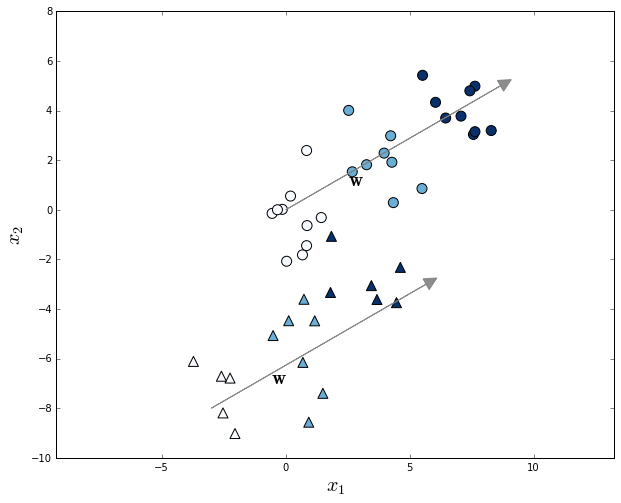

In [12]:
X_train, y_train, b_train, X_test, y_test, b_test, w = get_plot_data()

Our goal is to learn an approximation, $\hat{\bf w}$, that can be used to accurately rate future unseen data based on alternate queries.  One (foolish) way to attempt this is to fit a a linear classifier to the data.  Let's try this with simple Ridge Regression. 

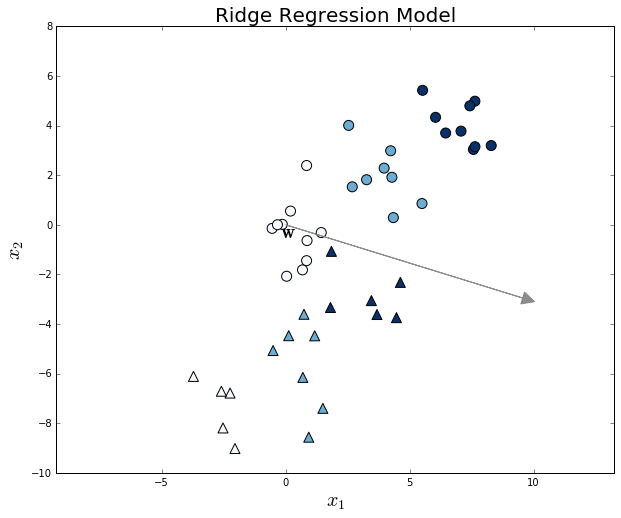

In [13]:
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
wridge = regr.coef_ / np.linalg.norm(regr.coef_)
plot_data_w(X_train, y_train, b_train, wridge, "Ridge Regression Model")

Here we see the problem.  Because we have not done anything to tell the learning algorithm to treat the two different sets of query data separately, we get a linear model that is skewed by the pair-wise interaction of query-document pairs from different queries. 

To evaluate our model we'll use *Kendall's tau correlation coefficient* on each set of query data, given by 

$$
\tau = \frac{P-Q}{P+Q}
$$

where $P$ is the number of concordant pairs (i.e. pairs that are correctly ordered w.r.t. to the labeling) and $Q$ is the number of discordant pairs (i.e. pairs that are incorrectly ordered w.r.t. the labeling).  Note that the sklearn implementation of Kendall's Tau is slightly different than this, but in any case it gives a measure in $[-1, 1]$ where numbers close to $1$ indicate a faithful ordering in the data and numbers close to $-1$ indicate a poor ordering of the data.  

In [14]:
for i in range(2):
    tau, _ = stats.kendalltau(
        regr.predict(X_test[b_test == i]), y_test[b_test == i])
    print('Kendall correlation coefficient for block %s: %.5f' % (i, tau))

Kendall correlation coefficient for block 0: 0.81661
Kendall correlation coefficient for block 1: 0.82064


**Q**: Which points in each block are mis-ranked by the Ridge Regression estimate of $\hat{\bf w}$? 

<br>

One way to get a more faithful approximation of ${\bf w}$ is to turn the problem into a binary classification problem using a pairwise transformation and then use a Support Vector Machine to do classification.  

The pairwise transformation we'll use is as follows 

$$
({\bf x}_k', y_k') = ({\bf x}_i - {\bf x}_j, \textrm{sign}(y_i - y_j)) ~~~ \textrm{for all comparable pairs} ~ (i,j) 
$$

**Q**: What do we mean by *for all comparable pairs*? 

**A**: It only makes sense to compare (1) vectors corresponding to the same query and (2) vectors whose labels are different (inter-label pairings return 0 as a label which does not allow discrimination) 

**Q**: What dot he binary labels represent? 

**A**: Since we take the sign of the label differences the positive binary labels encode $\texttt{is more relevant than}$ and the negative binary labels encode $\texttt{is less relevant than}$. 

The following plot shows the pairwise difference features.  The colors represent the size of the label differences. 

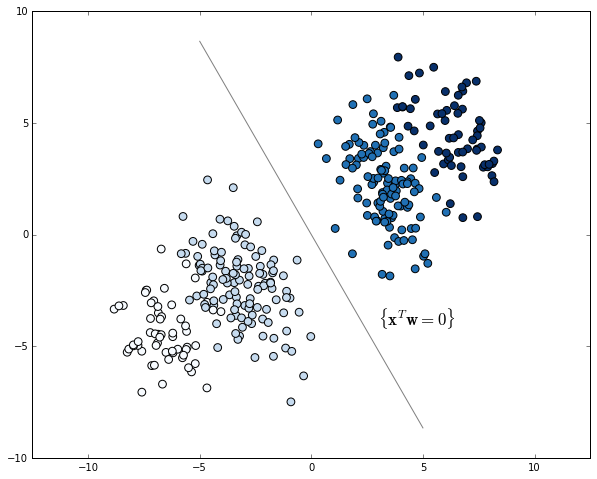

In [17]:
Xp, yp = get_plot_comparable_pairs(X_train, y_train, b_train, w)

 Notice that the true vector ${\bf w}$ perfectly separates the pair-wise differences.  This may not always be the case, for instance if there are discordant pairs in the training data due to mistakes in labeling by the experts. 
 
 Our goal now is to use a Support Vector Machine to learn an approximation $\hat{\bf w}$ to the true ranking vector ${\bf w}$. 

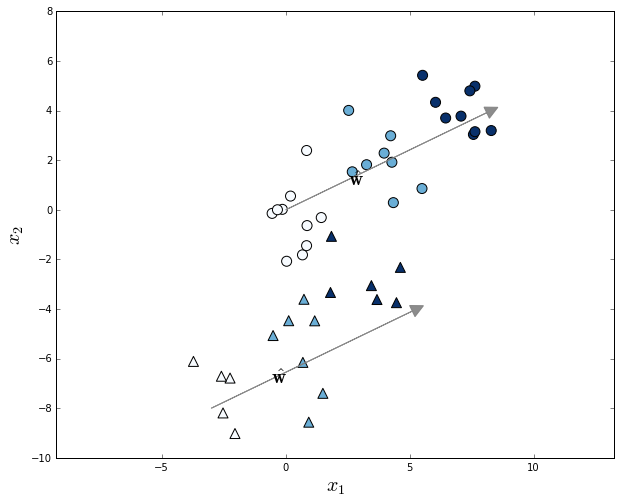

In [19]:
clf = svm.SVC(kernel="linear", C = 0.1)
clf.fit(Xp, yp)
wsvm = (clf.coef_ / np.linalg.norm(clf.coef_))[0]
plot_approximate_rank(X_train, y_train, b_train, wsvm)

Looks pretty good!  Let's compute Kendall's tau for the SVM-based ranking. 

In [20]:
for i in range(2):
    tau, _ = stats.kendalltau(
                np.dot(X_test[b_test == i], wsvm), y_test[b_test == i])
    print('Kendall correlation coefficient for block %s: %.5f' % (i, tau))

Kendall correlation coefficient for block 0: 0.83034
Kendall correlation coefficient for block 1: 0.83627


Notice that we obtained improvement over the Ridge Regression method. 

<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br>

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

<a id='helpers'></a>

### Helper Functions
***

In [1]:
import itertools
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm, linear_model, cross_validation

def get_plot_data():

    np.random.seed(1234)
    theta = np.pi / 3 
    w = np.array([np.sin(theta), np.cos(theta)])
    numPts = 30
    X = np.random.randn(numPts, 2)
    y = [0] * numPts
    for i in range(1, 3):
        X = np.concatenate((X, np.random.randn(numPts, 2) + i * 4 * w))
        y = np.concatenate((y, [i] * numPts))

    # slightly displace data corresponding to our second partition
    X[::2] -= np.array([3, 7]) 
    blocks = np.array([0, 1] * (X.shape[0] / 2))

    # split into train and test set
    cv = cross_validation.StratifiedShuffleSplit(y, test_size=.5)
    train, test = iter(cv).next()
    X_train, y_train, b_train = X[train], y[train], blocks[train]
    X_test, y_test, b_test = X[test], y[test], blocks[test]

    # plot the result
    idx = (b_train == 0)
    fig = plt.figure(figsize=(10,8))
    plt.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], 
        marker='^', cmap=plt.cm.Blues, s=100)
    plt.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx],
        marker='o', cmap=plt.cm.Blues, s=100)
    plt.arrow(0, 0, 10 * w[0], 10 * w[1], fc='gray', ec='gray', 
        head_width=0.5, head_length=0.5, alpha=0.9)
    plt.text(2.5, 1, r"${\bf w}$", fontsize=20)
    plt.arrow(-3, -8, 10 * w[0], 10 * w[1], fc='gray', ec='gray', 
        head_width=0.5, head_length=0.5, alpha=0.9)
    plt.text(-0.6, -7, r"${\bf w}$", fontsize=20)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20)
    plt.axis('equal')
    
    return X_train, y_train, b_train, X_test, y_test, b_test, w

def plot_data_w(X, y, b, w, tstr=""):
    
    idx = (b == 0)
    fig = plt.figure(figsize=(10,8))
    plt.scatter(X[idx, 0], X[idx, 1], c=y[idx], 
        marker='^', cmap=plt.cm.Blues, s=100)
    plt.scatter(X[~idx, 0], X[~idx, 1], c=y[~idx],
        marker='o', cmap=plt.cm.Blues, s=100)
    plt.arrow(0, 0, 10 * w[0], 10 * w[1], fc='gray', ec='gray', 
        head_width=0.5, head_length=0.5, alpha=0.9)
    plt.text(-0.25, -0.5, r"${\bf w}$", fontsize=20)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20)
    plt.title(tstr, fontsize=20)
    plt.axis('equal')
    
def get_plot_comparable_pairs(X_train, y_train, b_train, w):
    comb = itertools.combinations(range(X_train.shape[0]), 2)
    k = 0
    Xp, yp, diff = [], [], []
    for (i, j) in comb:
        if y_train[i] == y_train[j] \
            or b_train[i] != b_train[j]:
            #or blocks[train][i] != blocks[train][j]:
            # skip if same target or different group
            continue
        Xp.append(X_train[i] - X_train[j])
        diff.append(y_train[i] - y_train[j])
        yp.append(np.sign(diff[-1]))
        # output balanced classes
        if yp[-1] != (-1) ** k:
            yp[-1] *= -1
            Xp[-1] *= -1
            diff[-1] *= -1
        k += 1
    Xp, yp, diff = map(np.asanyarray, (Xp, yp, diff))
    fig = plt.figure(figsize=(10,8))
    plt.scatter(Xp[:, 0], Xp[:, 1], c=diff, s=60, marker='o', cmap=plt.cm.Blues)
    x_space = np.linspace(-10, 10)
    plt.plot(x_space * w[1], - x_space * w[0], color='gray')
    plt.text(3, -4, r'$\{{\bf x}^T {\bf w} = 0\}$', fontsize=17)
    plt.axis('equal')
    
    return Xp, yp 

def plot_approximate_rank(X_train, y_train, blocks, what): 
    # plot the result
    idx = (b_train == 0)
    fig = plt.figure(figsize=(10,8))
    plt.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], 
        marker='^', cmap=plt.cm.Blues, s=100)
    plt.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx],
        marker='o', cmap=plt.cm.Blues, s=100)
    plt.arrow(0, 0, 9 * what[0], 9 * what[1], fc='gray', ec='gray', 
        head_width=0.5, head_length=0.5, alpha=0.9)
    plt.text(2.5, 1, r"$\hat{\bf w}$", fontsize=20)
    plt.arrow(-3, -8, 9 * what[0], 9 * what[1], fc='gray', ec='gray', 
        head_width=0.5, head_length=0.5, alpha=0.9)
    plt.text(-0.6, -7, r"$\hat{\bf w}$", fontsize=20)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20)
    plt.axis('equal')
    
from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")